In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\neupa\OneDrive\Desktop\data606_capstone_teamC\Data\fake_news_0\WELFake_Dataset.csv")

In [4]:
df.drop("Unnamed: 0", inplace=True, axis=1)
df.dropna(inplace=True) # some null values are causing problems while doing visualization

In [5]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71537 non-null  object
 1   text    71537 non-null  object
 2   label   71537 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [7]:
df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


<b> Here, label 0 means fake news and 1 means real news which is kind of confusing. So, lets replace these labels.

In [8]:
df["label"] = df["label"].map({0: 1, 1: 0})

NOw, fake = 1

In [9]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

Not many null values compared to the size of the dataset. We can safely exclude the NaNs while training the models.

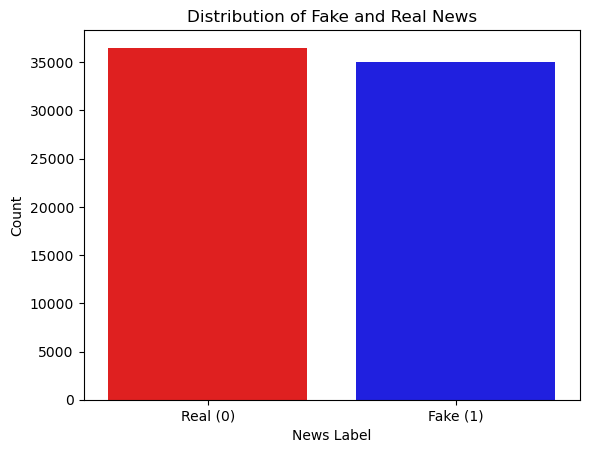

In [10]:
sns.countplot(x='label', data=df, palette=["red", "blue"])
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.title('Distribution of Fake and Real News')
plt.xlabel('News Label')
plt.ylabel('Count')
plt.show()

The dataset looks fairly balanced. This is good as we won't have to worry about class imbalance.

In [11]:
df['title_length'] = df['title'].str.len()
df['text_length'] = df['text'].str.len()

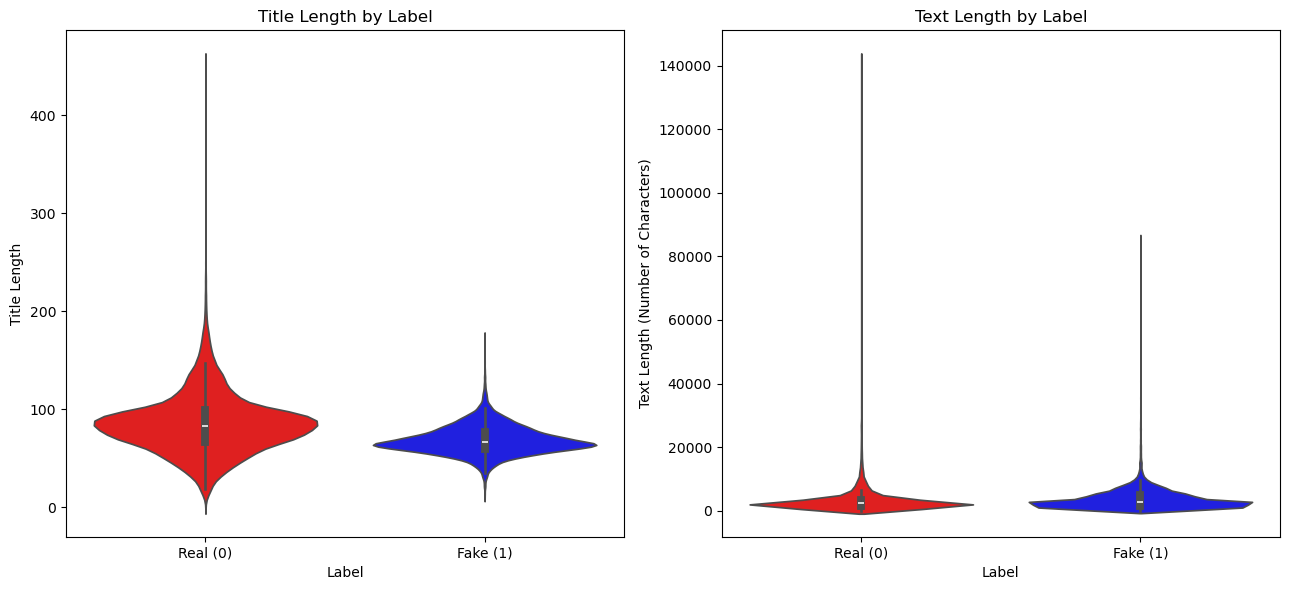

In [15]:
plt.figure(figsize=(13, 6))

# read = real and blue means fake
colors = ['red', 'blue']
plt.subplot(1,2,1)
sns.violinplot(x='label', y='title_length', data=df, palette=colors)
plt.title('Title Length by Label')
plt.xlabel('Label')
plt.ylabel('Title Length')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])

plt.subplot(1,2,2)
sns.violinplot(x='label', y='text_length', data=df, palette=colors)
plt.title('Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Text Length (Number of Characters)')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

In [16]:
df['title_words_length'] =  df['title'].str.split().apply(len)
df['text_word_length'] = df['text'].str.split().apply(len)

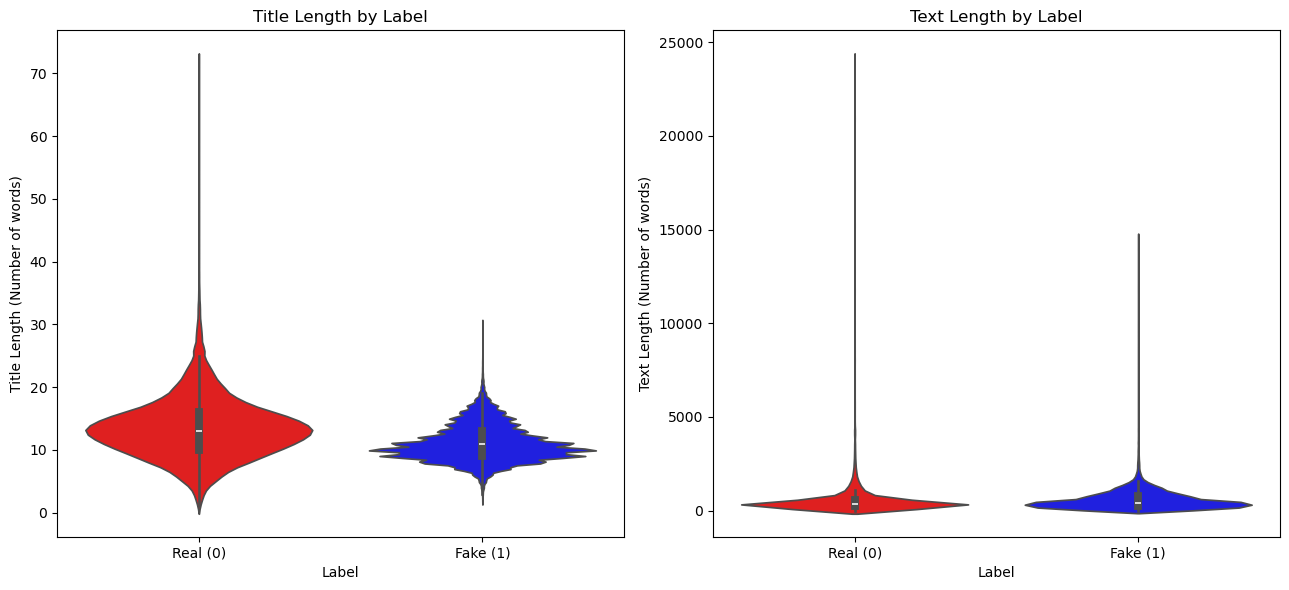

In [17]:
plt.figure(figsize=(13, 6))

# read = real and blue means fake
colors = ['red', 'blue']
plt.subplot(1,2,1)
sns.violinplot(x='label', y='title_words_length', data=df, palette=colors)
plt.title('Title Length by Label')
plt.xlabel('Label')
plt.ylabel('Title Length (Number of words)')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])

plt.subplot(1,2,2)
sns.violinplot(x='label', y='text_word_length', data=df, palette=colors)
plt.title('Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Text Length (Number of words)')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

This is a violinplot (distribution plot + boxplot in the center). The title length looks normally distributed whereas the text length is very much skewed to the right. This is interesting as if there are lots of text with relatively few words, they may not mean anything. We will see this in detailed analysis later on.

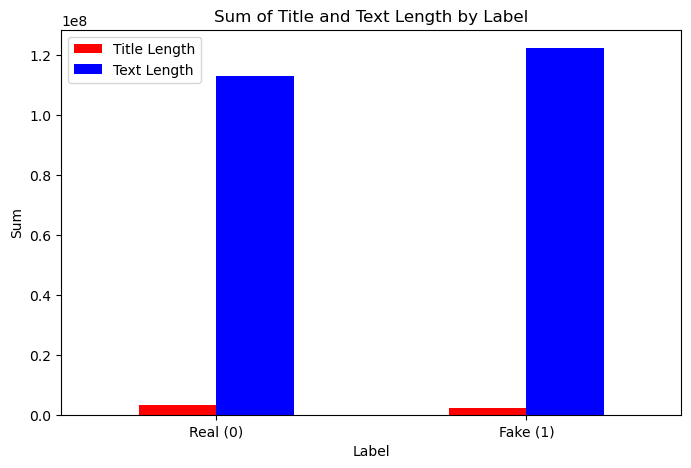

In [18]:
length_sums = df.groupby('label')[['title_length', 'text_length']].sum()

fig, ax = plt.subplots(figsize=(8,5))
length_sums.plot(kind='bar', color=colors, ax=ax)
plt.title('Sum of Title and Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Sum')
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'], rotation=0)
plt.legend(['Title Length', 'Text Length'], loc="upper left")
plt.show()

Hmm. not useful analysis. 

In [19]:
from wordcloud import WordCloud

In [20]:
# combining texts for title and text for real and fake news to create word clouds for both
fake_text_combined = " ".join(df[df['label'] == 0]['title'].dropna())
real_text_combined = " ".join(df[df['label'] == 1]['title'].dropna())

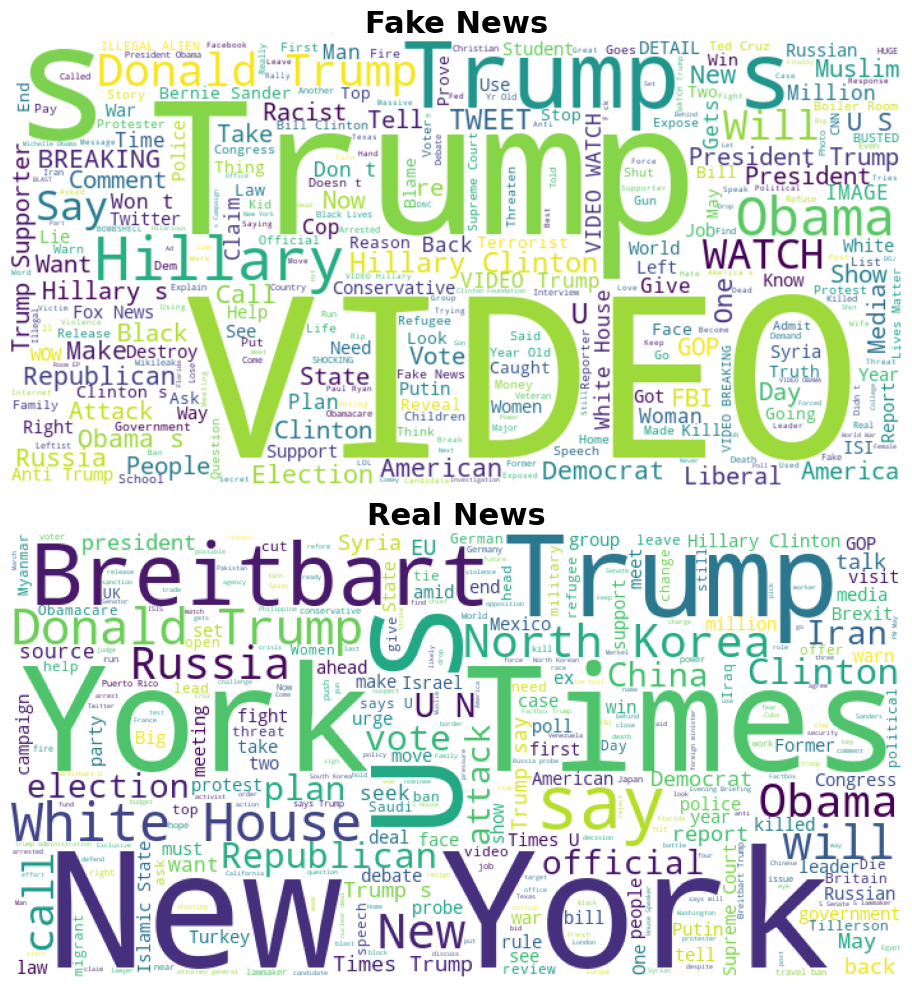

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
wordcloud_fake = WordCloud(background_color='white', max_words=300, width=700, height=350).generate(fake_text_combined)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].set_title('Fake News', fontsize=22, fontweight='bold')
axes[0].axis("off")

wordcloud_real = WordCloud(background_color='white', max_words=300, width=700, height=350,).generate(real_text_combined)
axes[1].imshow(wordcloud_real)
axes[1].set_title('Real News', fontsize=22, fontweight='bold')
axes[1].axis("off")
plt.tight_layout()
plt.show()

These two wordclouds are interesting actually:

In Fake news wordcloud, we see that words like Video, Watch, Tweet, Breaking, and political figures dominate, which are often used commonly to clickbait and grab attention. Fake news seem to rely a lot on provocative and emotional language like kill, racist, and fairly negative stuff.

Real news, however, contains terms like New York Times, White House, law, etc which are kind of commonly utilized in reporting agencies. 

One key aspect we can see is that fake news is all about anger/fear and outrage whereas real news looks slightly moderate.